# Lab 6 CNN's

Wyatt Saltzman and Landon Wood
Dr. Larson
CS 7324

In [69]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
%matplotlib inline

print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('Tensorflow version:', tf.__version__)

Pandas version: 2.0.3
Numpy version: 1.24.3
Tensorflow version: 2.13.0


## Choose which metric we want to use...

In [58]:
IMG_HEIGHT = 32
IMG_WIDTH = 32
N_CLASSES = 10

tf.random.set_seed(2)
np.random.seed(0)
tf.config.list_physical_devices('GPU')

# Load the data
(X, y), _ = tf.keras.datasets.cifar10.load_data()

# Convert to grayscale
X = tf.image.rgb_to_grayscale(X).numpy()

# Normalize the data
X = X / 255.0

print('X_train shape:', X.shape)
print('y_train shape:', y.shape)

X_train shape: (50000, 32, 32, 1)
y_train shape: (50000, 1)


| Label | Description |
| --- | --- |
| 0 | airplane |
| 1 | automobile |
| 2 | bird |
| 3 | cat |
| 4 | deer |
| 5 | dog |
| 6 | frog |
| 7 | horse |
| 8 | ship |
| 9 | truck |

In [59]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Split the data and justify your choice of validation scheme.

In [60]:
# only use 3000 samples
X = X[:3000]
y = y[:3000]

# print out the distribution of the labels
unique, counts = np.unique(y, return_counts=True)
print('Label distribution:', dict(zip(unique, counts)))

Label distribution: {0: 299, 1: 287, 2: 322, 3: 285, 4: 311, 5: 279, 6: 312, 7: 297, 8: 308, 9: 300}


In [61]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (2400, 32, 32, 1)
y_train shape: (2400, 1)


In [62]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

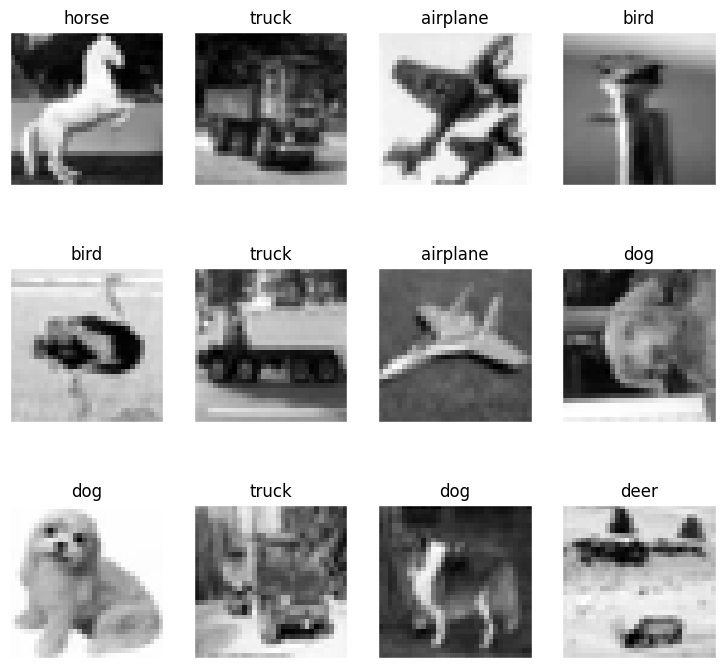

In [63]:
# Plot images
plt.style.use('ggplot')

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(labels[int(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X_train, y_train, IMG_HEIGHT, IMG_WIDTH)

In [64]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

# print('Keras version:', keras.__version__)

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_13 (RandomFlip  (None, 32, 32, 1)         0         
 )                                                               
                                                                 
 random_rotation_13 (Random  (None, 32, 32, 1)         0         
 Rotation)                                                       
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 activation_8 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                               

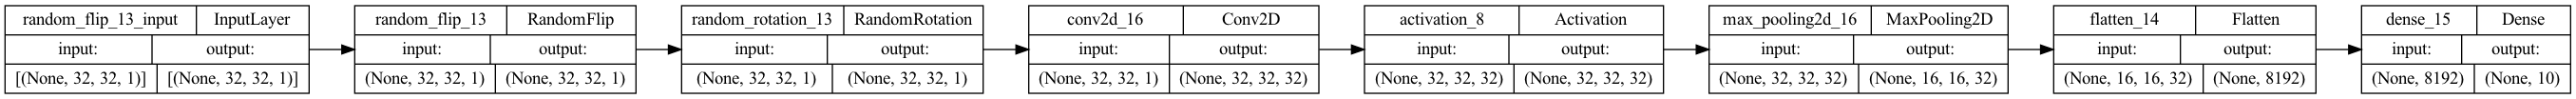

In [94]:
# one hot encode outputs
y_train_ohe = keras.utils.to_categorical(y_train, N_CLASSES)
y_test_ohe = keras.utils.to_categorical(y_test, N_CLASSES)

# Define the model
cnn = Sequential(name='cnn')
# Add data augmentation layers
cnn.add(RandomFlip('horizontal'))
cnn.add(RandomRotation(0.2))

# Add convolutional layers
cnn.add(Conv2D(32, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn.add(Flatten())
cnn.add(Dense(N_CLASSES, activation='softmax'))

# Build the model
cnn.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 1))

print(cnn.summary())

# Plot the model
plot_model(
    cnn, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [102]:
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cnn_history = cnn.fit(X_train, y_train_ohe, epochs=50, batch_size=128, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=1)

Epoch 1/50


2023-11-15 10:10:27.637981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 10:10:27.862972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/19 [===>..........................] - ETA: 1s - loss: 2.3250 - accuracy: 0.0990

2023-11-15 10:10:29.925751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:29.994676: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.063734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 2.3061 - accuracy: 0.1081

2023-11-15 10:10:30.132263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.198378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.262562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 2.3012 - accuracy: 0.1141

2023-11-15 10:10:30.336660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.403938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.468347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/19 [===================>..........] - ETA: 0s - loss: 2.2947 - accuracy: 0.1232

2023-11-15 10:10:30.537516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.603439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.667908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.735853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/19 [=========================>....] - ETA: 0s - loss: 2.2877 - accuracy: 0.1392

2023-11-15 10:10:30.797243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.859573: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.919883: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:30.981812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 2.2845 - accuracy: 0.1415

2023-11-15 10:10:31.048502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.2811 - accuracy: 0.1467

2023-11-15 10:10:32.422619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 6s 194ms/step - loss: 2.2811 - accuracy: 0.1467 - val_loss: 2.1924 - val_accuracy: 0.2417
Epoch 2/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.1975 - accuracy: 0.2318

2023-11-15 10:10:33.418140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.481127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.538696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.599833: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.2026 - accuracy: 0.2176

2023-11-15 10:10:33.656065: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.712786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.772340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.831223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.1930 - accuracy: 0.2294

2023-11-15 10:10:33.889132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:33.946627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.006039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.060574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.1913 - accuracy: 0.2214

2023-11-15 10:10:34.119796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.175920: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.232905: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.289947: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.1836 - accuracy: 0.2150

2023-11-15 10:10:34.346095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.404559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.462904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 2.1836 - accuracy: 0.2150 - val_loss: 2.1208 - val_accuracy: 0.2100
Epoch 3/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.1434 - accuracy: 0.2292

2023-11-15 10:10:34.758707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.815963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.873921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:34.930830: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.1318 - accuracy: 0.2299

2023-11-15 10:10:34.995032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.057289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.116041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.174875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.1318 - accuracy: 0.2280

2023-11-15 10:10:35.231818: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.289171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.348563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.407801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.1277 - accuracy: 0.2302

2023-11-15 10:10:35.465047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.522268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.581926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.638284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.1226 - accuracy: 0.2300

2023-11-15 10:10:35.695541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.751261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:35.808063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 2.1226 - accuracy: 0.2300 - val_loss: 2.0639 - val_accuracy: 0.2733
Epoch 4/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.0969 - accuracy: 0.2708

2023-11-15 10:10:36.101620: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.157767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.215476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.274601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0866 - accuracy: 0.2656

2023-11-15 10:10:36.333511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.391385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.447277: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.502524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0961 - accuracy: 0.2493

2023-11-15 10:10:36.558529: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.613782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.672323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.731297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0930 - accuracy: 0.2495

2023-11-15 10:10:36.790876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.846185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.905281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:36.961271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0906 - accuracy: 0.2475

2023-11-15 10:10:37.018717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.076682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.132762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 2.0906 - accuracy: 0.2475 - val_loss: 2.0558 - val_accuracy: 0.2550
Epoch 5/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.1016 - accuracy: 0.2057

2023-11-15 10:10:37.420149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.475451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.532777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.592075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0456 - accuracy: 0.2645

2023-11-15 10:10:37.650666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.707032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.762089: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.818019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0552 - accuracy: 0.2557

2023-11-15 10:10:37.874111: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.932945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:37.989393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.046059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0622 - accuracy: 0.2516

2023-11-15 10:10:38.103769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.159817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.215120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.274135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0510 - accuracy: 0.2550

2023-11-15 10:10:38.330695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.390604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.447874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 2.0510 - accuracy: 0.2550 - val_loss: 2.0171 - val_accuracy: 0.2933
Epoch 6/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.0834 - accuracy: 0.2656

2023-11-15 10:10:38.741330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.800524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.857965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:38.914140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0484 - accuracy: 0.2545

2023-11-15 10:10:38.969532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.025152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.083783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.140871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0267 - accuracy: 0.2706

2023-11-15 10:10:39.198864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.256610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.313312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.372067: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0305 - accuracy: 0.2609

2023-11-15 10:10:39.429924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.484959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.542054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.598710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0295 - accuracy: 0.2696

2023-11-15 10:10:39.655292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.713163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:39.768333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 2.0295 - accuracy: 0.2696 - val_loss: 1.9727 - val_accuracy: 0.2983
Epoch 7/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.0087 - accuracy: 0.3099

2023-11-15 10:10:40.057926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.113974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.172997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.228709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0305 - accuracy: 0.2712

2023-11-15 10:10:40.284381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.340022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.395392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.452655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0094 - accuracy: 0.2791

2023-11-15 10:10:40.509345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.565320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.623999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.679999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0031 - accuracy: 0.2823

2023-11-15 10:10:40.734813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.790184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.846907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:40.905502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0021 - accuracy: 0.2754

2023-11-15 10:10:40.961886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.018372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.073821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 2.0021 - accuracy: 0.2754 - val_loss: 1.9412 - val_accuracy: 0.3233
Epoch 8/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.0213 - accuracy: 0.2760

2023-11-15 10:10:41.371595: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.427762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.484324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.543029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0033 - accuracy: 0.3069

2023-11-15 10:10:41.600265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.656679: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.712440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.770508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9963 - accuracy: 0.2933

2023-11-15 10:10:41.826233: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.885504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.941112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:41.997335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9833 - accuracy: 0.3042

2023-11-15 10:10:42.052655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.108435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.163520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.222410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9819 - accuracy: 0.3050

2023-11-15 10:10:42.282444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.339980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.396386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.9819 - accuracy: 0.3050 - val_loss: 1.9072 - val_accuracy: 0.3200
Epoch 9/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.9446 - accuracy: 0.3177

2023-11-15 10:10:42.695059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.753978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.809152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.865596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9504 - accuracy: 0.3225

2023-11-15 10:10:42.924008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:42.980049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.038217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.093523: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9771 - accuracy: 0.2940

2023-11-15 10:10:43.162668: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.228262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.286242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.341555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9643 - accuracy: 0.2953

2023-11-15 10:10:43.399851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.458355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.516810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.575337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9614 - accuracy: 0.2992

2023-11-15 10:10:43.630548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.685227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:43.741549: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 1.9614 - accuracy: 0.2992 - val_loss: 1.9066 - val_accuracy: 0.3050
Epoch 10/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.9454 - accuracy: 0.3021

2023-11-15 10:10:44.038784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.097456: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.155203: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.214073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9259 - accuracy: 0.3092

2023-11-15 10:10:44.269911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.325195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.380135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.435179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9401 - accuracy: 0.3026

2023-11-15 10:10:44.489729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.546781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.604231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.659796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9515 - accuracy: 0.3005

2023-11-15 10:10:44.718137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.773161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.828369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:44.887559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9478 - accuracy: 0.3054

2023-11-15 10:10:44.943410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.000398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.055900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.9478 - accuracy: 0.3054 - val_loss: 1.8750 - val_accuracy: 0.3217
Epoch 11/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.9870 - accuracy: 0.3047

2023-11-15 10:10:45.342221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.400479: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.455950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.510522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9596 - accuracy: 0.2991

2023-11-15 10:10:45.568493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.624209: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.681041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.740380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9396 - accuracy: 0.3139

2023-11-15 10:10:45.796444: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.851880: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.909173: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:45.966500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9298 - accuracy: 0.3182

2023-11-15 10:10:46.025730: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.083589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.138647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.217651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9224 - accuracy: 0.3212

2023-11-15 10:10:46.280508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.338762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.396177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 72ms/step - loss: 1.9224 - accuracy: 0.3212 - val_loss: 1.8776 - val_accuracy: 0.3200
Epoch 12/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.9191 - accuracy: 0.3281

2023-11-15 10:10:46.691491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.750079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.808185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.863225: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9065 - accuracy: 0.3181

2023-11-15 10:10:46.919894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:46.975020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.033066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.088737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9089 - accuracy: 0.3217

2023-11-15 10:10:47.146121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.203025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.259446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.315931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9072 - accuracy: 0.3245

2023-11-15 10:10:47.377618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.435884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.494179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.560737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8986 - accuracy: 0.3304

2023-11-15 10:10:47.617732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.676274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:47.730101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8986 - accuracy: 0.3304 - val_loss: 1.8737 - val_accuracy: 0.3450
Epoch 13/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8833 - accuracy: 0.3333

2023-11-15 10:10:48.020692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.077807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.142719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.197887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8735 - accuracy: 0.3304

2023-11-15 10:10:48.253431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.309029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.364489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.422401: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8808 - accuracy: 0.3310

2023-11-15 10:10:48.477368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.535406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.594241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.650029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8788 - accuracy: 0.3307

2023-11-15 10:10:48.705797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.760059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.818393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.876335: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8818 - accuracy: 0.3296

2023-11-15 10:10:48.934375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:48.993490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.048664: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8818 - accuracy: 0.3296 - val_loss: 1.8712 - val_accuracy: 0.3233
Epoch 14/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8858 - accuracy: 0.3229

2023-11-15 10:10:49.334026: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.390891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.445930: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.500838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8939 - accuracy: 0.3248

2023-11-15 10:10:49.556104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.612037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.668175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.723327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9017 - accuracy: 0.3246

2023-11-15 10:10:49.779517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.835261: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.892647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:49.948984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8903 - accuracy: 0.3292

2023-11-15 10:10:50.007057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.063571: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.118490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.174281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8898 - accuracy: 0.3275

2023-11-15 10:10:50.233289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.291872: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.349781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8898 - accuracy: 0.3275 - val_loss: 1.8549 - val_accuracy: 0.3467
Epoch 15/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8339 - accuracy: 0.3724

2023-11-15 10:10:50.643991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.700491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.758421: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.814425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8377 - accuracy: 0.3605

2023-11-15 10:10:50.870307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.926524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:50.981957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.037565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8619 - accuracy: 0.3423

2023-11-15 10:10:51.093713: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.151489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.207409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.263323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8617 - accuracy: 0.3484

2023-11-15 10:10:51.323367: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.382776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.440911: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.497259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8622 - accuracy: 0.3487

2023-11-15 10:10:51.554372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.612436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:51.670647: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8622 - accuracy: 0.3487 - val_loss: 1.8390 - val_accuracy: 0.3617
Epoch 16/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.9101 - accuracy: 0.3307

2023-11-15 10:10:51.957235: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.015242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.070699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.126163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8706 - accuracy: 0.3415

2023-11-15 10:10:52.183999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.239995: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.294487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.349278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8722 - accuracy: 0.3388

2023-11-15 10:10:52.407777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.474614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.533388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.588161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8679 - accuracy: 0.3365

2023-11-15 10:10:52.644459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.705096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.760060: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.817301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8622 - accuracy: 0.3400

2023-11-15 10:10:52.874536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.930435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:52.986100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8622 - accuracy: 0.3400 - val_loss: 1.8256 - val_accuracy: 0.3500
Epoch 17/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8714 - accuracy: 0.3203

2023-11-15 10:10:53.278096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.334336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.392873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.446241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8639 - accuracy: 0.3426

2023-11-15 10:10:53.500467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.558378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.617960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.675366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8718 - accuracy: 0.3345

2023-11-15 10:10:53.731829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.788328: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.844155: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:53.900514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8705 - accuracy: 0.3333

2023-11-15 10:10:53.957352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.013873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.075120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.133420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8626 - accuracy: 0.3358

2023-11-15 10:10:54.189243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.247057: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.301840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8626 - accuracy: 0.3358 - val_loss: 1.8629 - val_accuracy: 0.3450
Epoch 18/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8736 - accuracy: 0.3359

2023-11-15 10:10:54.595970: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.651110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.709229: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.772033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8923 - accuracy: 0.3326

2023-11-15 10:10:54.831152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.885935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.941336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:54.997291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8870 - accuracy: 0.3345

2023-11-15 10:10:55.053170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.109504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.165377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.220819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8675 - accuracy: 0.3432

2023-11-15 10:10:55.277008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.332410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.388583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.444480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8670 - accuracy: 0.3421

2023-11-15 10:10:55.500058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.554802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.613977: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.8670 - accuracy: 0.3421 - val_loss: 1.8046 - val_accuracy: 0.3533
Epoch 19/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7969 - accuracy: 0.3385

2023-11-15 10:10:55.901001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:55.958055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.014351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.072803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8369 - accuracy: 0.3337

2023-11-15 10:10:56.129139: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.185739: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.243845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.301259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8503 - accuracy: 0.3374

2023-11-15 10:10:56.356808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.413554: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.468842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.525013: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8547 - accuracy: 0.3328

2023-11-15 10:10:56.580480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.635981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.693798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.750308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8548 - accuracy: 0.3375

2023-11-15 10:10:56.808697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.864699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:56.919718: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.8548 - accuracy: 0.3375 - val_loss: 1.8988 - val_accuracy: 0.3233
Epoch 20/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8436 - accuracy: 0.3490

2023-11-15 10:10:57.205819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.262913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.318597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.374490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8391 - accuracy: 0.3583

2023-11-15 10:10:57.431832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.489541: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.547657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.602377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8317 - accuracy: 0.3544

2023-11-15 10:10:57.658743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.714859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.770130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.825813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8265 - accuracy: 0.3562

2023-11-15 10:10:57.881974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.937626: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:57.995621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.052861: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8362 - accuracy: 0.3554

2023-11-15 10:10:58.109923: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.164791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.219711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.8362 - accuracy: 0.3554 - val_loss: 1.8172 - val_accuracy: 0.3633
Epoch 21/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7913 - accuracy: 0.3620

2023-11-15 10:10:58.507835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.563608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.619119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.677240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8134 - accuracy: 0.3638

2023-11-15 10:10:58.732876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.791643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.849548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:58.907906: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8124 - accuracy: 0.3615

2023-11-15 10:10:58.965291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.022310: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.082520: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.138941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8134 - accuracy: 0.3620

2023-11-15 10:10:59.195100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.251370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.306682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.364075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8162 - accuracy: 0.3625

2023-11-15 10:10:59.420320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.478434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.534539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8162 - accuracy: 0.3625 - val_loss: 1.8510 - val_accuracy: 0.3433
Epoch 22/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8374 - accuracy: 0.3151

2023-11-15 10:10:59.817897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.876428: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.931285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:10:59.986285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8338 - accuracy: 0.3382

2023-11-15 10:11:00.042657: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.097615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.155003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.212365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8204 - accuracy: 0.3551

2023-11-15 10:11:00.270472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.326794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.383879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.439296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8188 - accuracy: 0.3490

2023-11-15 10:11:00.496032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.551726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.607602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.662940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8296 - accuracy: 0.3458

2023-11-15 10:11:00.718878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.774729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:00.829614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8296 - accuracy: 0.3458 - val_loss: 1.8511 - val_accuracy: 0.3533
Epoch 23/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8180 - accuracy: 0.3802

2023-11-15 10:11:01.131687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.188831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.247737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.303544: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7861 - accuracy: 0.3761

2023-11-15 10:11:01.359740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.416359: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.472269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.531278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8050 - accuracy: 0.3594

2023-11-15 10:11:01.589964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.646701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.700285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.755662: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8194 - accuracy: 0.3589

2023-11-15 10:11:01.811510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.870317: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.926120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:01.980786: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8210 - accuracy: 0.3550

2023-11-15 10:11:02.048692: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.116408: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.177064: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 1.8210 - accuracy: 0.3550 - val_loss: 1.7900 - val_accuracy: 0.3617
Epoch 24/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8618 - accuracy: 0.3490

2023-11-15 10:11:02.461592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.519747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.576172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.635354: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8001 - accuracy: 0.3783

2023-11-15 10:11:02.697388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.754223: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.809570: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.863810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8112 - accuracy: 0.3800

2023-11-15 10:11:02.920782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:02.977299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.035242: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.093286: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8002 - accuracy: 0.3823

2023-11-15 10:11:03.151740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.207389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.262485: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.318888: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8097 - accuracy: 0.3729

2023-11-15 10:11:03.377989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.434266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.492201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8097 - accuracy: 0.3729 - val_loss: 1.7900 - val_accuracy: 0.3700
Epoch 25/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7989 - accuracy: 0.3490

2023-11-15 10:11:03.783095: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.838796: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.896879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:03.954974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8125 - accuracy: 0.3538

2023-11-15 10:11:04.010828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.068779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.124140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.180070: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8154 - accuracy: 0.3580

2023-11-15 10:11:04.235420: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.291236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.347184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.402835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8241 - accuracy: 0.3536

2023-11-15 10:11:04.461297: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.516946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.572961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.628581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8118 - accuracy: 0.3533

2023-11-15 10:11:04.684960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.743495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:04.798845: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.8118 - accuracy: 0.3533 - val_loss: 1.8277 - val_accuracy: 0.3367
Epoch 26/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7819 - accuracy: 0.3411

2023-11-15 10:11:05.089783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.147415: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.204926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.263293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8067 - accuracy: 0.3538

2023-11-15 10:11:05.320118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.379090: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.434792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.490341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8135 - accuracy: 0.3629

2023-11-15 10:11:05.549874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.605615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.664271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.719886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8249 - accuracy: 0.3573

2023-11-15 10:11:05.779768: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.835683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.890904: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:05.947522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8187 - accuracy: 0.3554

2023-11-15 10:11:06.001942: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.062886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.118985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8187 - accuracy: 0.3554 - val_loss: 1.8309 - val_accuracy: 0.3383
Epoch 27/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8621 - accuracy: 0.3411

2023-11-15 10:11:06.403440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.462406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.517945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.572881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8462 - accuracy: 0.3549

2023-11-15 10:11:06.628425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.687585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.745755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.801575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8048 - accuracy: 0.3707

2023-11-15 10:11:06.857798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.917843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:06.974198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.032594: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8138 - accuracy: 0.3651

2023-11-15 10:11:07.088811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.145464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.202198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.258019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8128 - accuracy: 0.3642

2023-11-15 10:11:07.313068: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.372104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.430460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.8128 - accuracy: 0.3642 - val_loss: 1.7846 - val_accuracy: 0.3750
Epoch 28/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8000 - accuracy: 0.3620

2023-11-15 10:11:07.711138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.766029: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.821826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.880884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7988 - accuracy: 0.3717

2023-11-15 10:11:07.939513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:07.997075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.052708: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.110618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7981 - accuracy: 0.3714

2023-11-15 10:11:08.168104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.225424: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.283433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.339165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7920 - accuracy: 0.3708

2023-11-15 10:11:08.396951: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.452138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.508928: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.564154: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7968 - accuracy: 0.3667

2023-11-15 10:11:08.620460: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.676802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:08.734971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7968 - accuracy: 0.3667 - val_loss: 1.7746 - val_accuracy: 0.3817
Epoch 29/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7532 - accuracy: 0.4036

2023-11-15 10:11:09.016794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.075204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.130526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.188380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7284 - accuracy: 0.4096

2023-11-15 10:11:09.244606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.301273: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.355699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.413963: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7651 - accuracy: 0.3920

2023-11-15 10:11:09.470513: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.529368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.586337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.641346: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7812 - accuracy: 0.3760

2023-11-15 10:11:09.697842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.753686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.811099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.868740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7828 - accuracy: 0.3800

2023-11-15 10:11:09.928488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:09.986468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.041464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 1.7828 - accuracy: 0.3800 - val_loss: 1.9355 - val_accuracy: 0.3350
Epoch 30/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8221 - accuracy: 0.3411

2023-11-15 10:11:10.347795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.403614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.460243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.518621: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8341 - accuracy: 0.3471

2023-11-15 10:11:10.575532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.631098: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.689512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.747011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8280 - accuracy: 0.3530

2023-11-15 10:11:10.802546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.861028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.920499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:10.975628: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8083 - accuracy: 0.3646

2023-11-15 10:11:11.032135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.088132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.146425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.201672: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8018 - accuracy: 0.3642

2023-11-15 10:11:11.257777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.316689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.375921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.8018 - accuracy: 0.3642 - val_loss: 1.7885 - val_accuracy: 0.3550
Epoch 31/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7490 - accuracy: 0.4062

2023-11-15 10:11:11.669006: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.725480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.780992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.838909: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7835 - accuracy: 0.3806

2023-11-15 10:11:11.896096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:11.952525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.009722: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.066222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7804 - accuracy: 0.3750

2023-11-15 10:11:12.122955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.178946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.237505: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.292578: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7905 - accuracy: 0.3688

2023-11-15 10:11:12.347117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.402468: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.457755: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.514889: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7728 - accuracy: 0.3775

2023-11-15 10:11:12.571234: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.629200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:12.685988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7728 - accuracy: 0.3775 - val_loss: 1.8044 - val_accuracy: 0.3783
Epoch 32/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7439 - accuracy: 0.3958

2023-11-15 10:11:12.967251: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.023703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.079134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.134762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7540 - accuracy: 0.3795

2023-11-15 10:11:13.189831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.247885: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.305278: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.363514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7413 - accuracy: 0.3750

2023-11-15 10:11:13.422988: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.479504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.537319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.593213: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7640 - accuracy: 0.3719

2023-11-15 10:11:13.650160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.706159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.765804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.823659: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7658 - accuracy: 0.3754

2023-11-15 10:11:13.882593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:13.940867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.001940: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7658 - accuracy: 0.3754 - val_loss: 1.7827 - val_accuracy: 0.3750
Epoch 33/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7209 - accuracy: 0.4089

2023-11-15 10:11:14.286936: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.344735: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.401937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.460813: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7640 - accuracy: 0.3739

2023-11-15 10:11:14.517355: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.573711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.629165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.684763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7655 - accuracy: 0.3750

2023-11-15 10:11:14.741719: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.800634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.858311: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:14.913736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7789 - accuracy: 0.3760

2023-11-15 10:11:14.969171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.025372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.081971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.140262: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7788 - accuracy: 0.3692

2023-11-15 10:11:15.197417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.253945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.311737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7788 - accuracy: 0.3692 - val_loss: 1.7780 - val_accuracy: 0.3883
Epoch 34/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7262 - accuracy: 0.4167

2023-11-15 10:11:15.595402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.651275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.705876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.761177: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7493 - accuracy: 0.3984

2023-11-15 10:11:15.817822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.876700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.932864: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:15.988849: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7778 - accuracy: 0.3786

2023-11-15 10:11:16.046917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.104351: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.160425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.218157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7684 - accuracy: 0.3854

2023-11-15 10:11:16.274841: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.332640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.388509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.443797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7745 - accuracy: 0.3796

2023-11-15 10:11:16.501270: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.556802: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.613014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7745 - accuracy: 0.3796 - val_loss: 1.7755 - val_accuracy: 0.3717
Epoch 35/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7537 - accuracy: 0.3932

2023-11-15 10:11:16.909761: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:16.968202: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.023014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.078325: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7722 - accuracy: 0.3929

2023-11-15 10:11:17.137873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.195801: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.255597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.311607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7717 - accuracy: 0.3786

2023-11-15 10:11:17.369500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.428079: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.485593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.541777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7817 - accuracy: 0.3698

2023-11-15 10:11:17.600546: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.656275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.713548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.768711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7714 - accuracy: 0.3742

2023-11-15 10:11:17.824806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.882895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:17.940172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7714 - accuracy: 0.3742 - val_loss: 1.7935 - val_accuracy: 0.3717
Epoch 36/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8106 - accuracy: 0.3438

2023-11-15 10:11:18.223037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.279170: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.335506: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.392025: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7589 - accuracy: 0.3761

2023-11-15 10:11:18.447879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.504376: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.560187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.619040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7609 - accuracy: 0.3722

2023-11-15 10:11:18.675797: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.734347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.789784: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.847811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7654 - accuracy: 0.3740

2023-11-15 10:11:18.910085: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:18.971497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.032315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.093194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7589 - accuracy: 0.3796

2023-11-15 10:11:19.149673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.205396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.260842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7589 - accuracy: 0.3796 - val_loss: 1.7921 - val_accuracy: 0.3783
Epoch 37/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7458 - accuracy: 0.3698

2023-11-15 10:11:19.542886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.602301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.657373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.712605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7798 - accuracy: 0.3672

2023-11-15 10:11:19.769985: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.825253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.885038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:19.943435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7568 - accuracy: 0.3842

2023-11-15 10:11:19.999198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.057073: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.112357: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.168107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7442 - accuracy: 0.3922

2023-11-15 10:11:20.223487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.281017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.337158: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.393188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7427 - accuracy: 0.3900

2023-11-15 10:11:20.448186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.504143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.559473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7427 - accuracy: 0.3900 - val_loss: 1.7529 - val_accuracy: 0.3850
Epoch 38/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7343 - accuracy: 0.4167

2023-11-15 10:11:20.849181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.905137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:20.960498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.019803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7303 - accuracy: 0.4096

2023-11-15 10:11:21.075682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.133990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.189579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.244163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7448 - accuracy: 0.3913

2023-11-15 10:11:21.303107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.358567: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.413946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.471643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7469 - accuracy: 0.3964

2023-11-15 10:11:21.527385: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.583140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.641686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.697559: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7570 - accuracy: 0.3867

2023-11-15 10:11:21.754175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.810493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:21.865150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7570 - accuracy: 0.3867 - val_loss: 1.8221 - val_accuracy: 0.3650
Epoch 39/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7629 - accuracy: 0.4036

2023-11-15 10:11:22.157002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.215049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.270315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.325952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7682 - accuracy: 0.3783

2023-11-15 10:11:22.382446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.438776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.494492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.552176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7519 - accuracy: 0.3807

2023-11-15 10:11:22.610685: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.670049: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.724653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.782330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7439 - accuracy: 0.3849

2023-11-15 10:11:22.841009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.896933: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:22.952508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.007763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7465 - accuracy: 0.3796

2023-11-15 10:11:23.066314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.121707: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.179061: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7465 - accuracy: 0.3796 - val_loss: 1.8070 - val_accuracy: 0.3767
Epoch 40/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7982 - accuracy: 0.3568

2023-11-15 10:11:23.468259: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.526514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.581742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.639740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7760 - accuracy: 0.3739

2023-11-15 10:11:23.698764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.755461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.813975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.869834: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7483 - accuracy: 0.3878

2023-11-15 10:11:23.927935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:23.983014: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.040050: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.097737: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7348 - accuracy: 0.3948

2023-11-15 10:11:24.156147: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.214129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.270011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.325913: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7466 - accuracy: 0.3829

2023-11-15 10:11:24.382238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.438666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.497865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7466 - accuracy: 0.3829 - val_loss: 1.7475 - val_accuracy: 0.4133
Epoch 41/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7877 - accuracy: 0.3802

2023-11-15 10:11:24.790034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.845736: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.904931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:24.961987: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7740 - accuracy: 0.3862

2023-11-15 10:11:25.018519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.075832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.133656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.194231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7581 - accuracy: 0.3842

2023-11-15 10:11:25.251981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.311702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.368336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.423088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7466 - accuracy: 0.3833

2023-11-15 10:11:25.479683: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.539540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.597729: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.656437: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7539 - accuracy: 0.3792

2023-11-15 10:11:25.712710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.771284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:25.827560: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 1.7539 - accuracy: 0.3792 - val_loss: 1.7659 - val_accuracy: 0.3983
Epoch 42/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.6949 - accuracy: 0.4323

2023-11-15 10:11:26.120927: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.179897: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.238814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.297285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7055 - accuracy: 0.4219

2023-11-15 10:11:26.355575: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.412589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.468615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.524804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7318 - accuracy: 0.4013

2023-11-15 10:11:26.583627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.639221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.694239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.752931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7312 - accuracy: 0.3927

2023-11-15 10:11:26.812295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.873838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:26.941965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.004188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7322 - accuracy: 0.3879

2023-11-15 10:11:27.065299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.121540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.179892: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 72ms/step - loss: 1.7322 - accuracy: 0.3879 - val_loss: 1.8131 - val_accuracy: 0.3783
Epoch 43/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.6798 - accuracy: 0.4271

2023-11-15 10:11:27.473333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.528706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.589397: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.644992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7393 - accuracy: 0.4029

2023-11-15 10:11:27.706819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.762221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.819451: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.877051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7508 - accuracy: 0.3892

2023-11-15 10:11:27.935996: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:27.991562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.048119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.114473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7511 - accuracy: 0.3859

2023-11-15 10:11:28.171548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.231598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.288410: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.343358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7549 - accuracy: 0.3887

2023-11-15 10:11:28.398847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.456898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.513299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 71ms/step - loss: 1.7549 - accuracy: 0.3887 - val_loss: 1.7448 - val_accuracy: 0.4033
Epoch 44/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7799 - accuracy: 0.3568

2023-11-15 10:11:28.801389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.859702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.916091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:28.971431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7518 - accuracy: 0.3783

2023-11-15 10:11:29.026960: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.083470: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.138853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.194598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7413 - accuracy: 0.3750

2023-11-15 10:11:29.251037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.307108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.362210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.418632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7338 - accuracy: 0.3781

2023-11-15 10:11:29.475577: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.531004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.589710: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.646118: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7297 - accuracy: 0.3846

2023-11-15 10:11:29.705002: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.760918: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:29.819780: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 69ms/step - loss: 1.7297 - accuracy: 0.3846 - val_loss: 1.7729 - val_accuracy: 0.3833
Epoch 45/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.6678 - accuracy: 0.4349

2023-11-15 10:11:30.103934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.162806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.227501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.283323: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7082 - accuracy: 0.4062

2023-11-15 10:11:30.339952: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.395746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.453877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.509467: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7197 - accuracy: 0.4041

2023-11-15 10:11:30.567587: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.626128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.682113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.737100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7361 - accuracy: 0.3974

2023-11-15 10:11:30.797046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.852580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.911022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:30.968592: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7361 - accuracy: 0.3938

2023-11-15 10:11:31.026765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.082109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.140870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7361 - accuracy: 0.3938 - val_loss: 1.7707 - val_accuracy: 0.3883
Epoch 46/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7170 - accuracy: 0.4193

2023-11-15 10:11:31.424968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.481615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.537547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.595087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7473 - accuracy: 0.4040

2023-11-15 10:11:31.651803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.707295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.765682: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.824472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7170 - accuracy: 0.4183

2023-11-15 10:11:31.880041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.938720: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:31.996487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.051925: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7434 - accuracy: 0.4000

2023-11-15 10:11:32.109873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.164726: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.223038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.279106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7423 - accuracy: 0.3996

2023-11-15 10:11:32.335120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.390748: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.446315: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7423 - accuracy: 0.3996 - val_loss: 1.7549 - val_accuracy: 0.4033
Epoch 47/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7249 - accuracy: 0.4141

2023-11-15 10:11:32.737991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.793120: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.849182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:32.904751: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7418 - accuracy: 0.3906

2023-11-15 10:11:32.961171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.016132: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.072231: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.131806: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7455 - accuracy: 0.3871

2023-11-15 10:11:33.191427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.248112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.309116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.367574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7500 - accuracy: 0.3771

2023-11-15 10:11:33.434660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.497653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.565762: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.626058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7445 - accuracy: 0.3825

2023-11-15 10:11:33.682525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.739391: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:33.798028: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 72ms/step - loss: 1.7445 - accuracy: 0.3825 - val_loss: 1.8011 - val_accuracy: 0.3867
Epoch 48/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7062 - accuracy: 0.3776

2023-11-15 10:11:34.095407: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.157919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.217131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.273416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7310 - accuracy: 0.3761

2023-11-15 10:11:34.330347: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.387605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.442531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.500777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7104 - accuracy: 0.3984

2023-11-15 10:11:34.556342: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.612187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.667548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.723041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7166 - accuracy: 0.3979

2023-11-15 10:11:34.779443: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.835230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.890697: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:34.948004: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7165 - accuracy: 0.3933

2023-11-15 10:11:35.002876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.061825: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.118419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7165 - accuracy: 0.3933 - val_loss: 1.7734 - val_accuracy: 0.3883
Epoch 49/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7478 - accuracy: 0.3516

2023-11-15 10:11:35.418186: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.473629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.531699: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.586593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7312 - accuracy: 0.3739

2023-11-15 10:11:35.643114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.699157: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.755508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.813205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.7222 - accuracy: 0.3864

2023-11-15 10:11:35.871332: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.926598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:35.981714: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.040121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7103 - accuracy: 0.4016

2023-11-15 10:11:36.096180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.155630: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.214166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.270183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7214 - accuracy: 0.3975

2023-11-15 10:11:36.329612: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.394268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.449945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7214 - accuracy: 0.3975 - val_loss: 1.7852 - val_accuracy: 0.3700
Epoch 50/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.6462 - accuracy: 0.3880

2023-11-15 10:11:36.737434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.794101: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.850375: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:36.908689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.6868 - accuracy: 0.3973

2023-11-15 10:11:36.965378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.025518: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.080624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.139248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.6812 - accuracy: 0.4006

2023-11-15 10:11:37.195765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.253247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.309245: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.364296: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.7153 - accuracy: 0.3901

2023-11-15 10:11:37.419922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.478961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.535123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.591548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.7172 - accuracy: 0.3938

2023-11-15 10:11:37.647931: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.704717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:37.760579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 70ms/step - loss: 1.7172 - accuracy: 0.3938 - val_loss: 1.7624 - val_accuracy: 0.4033


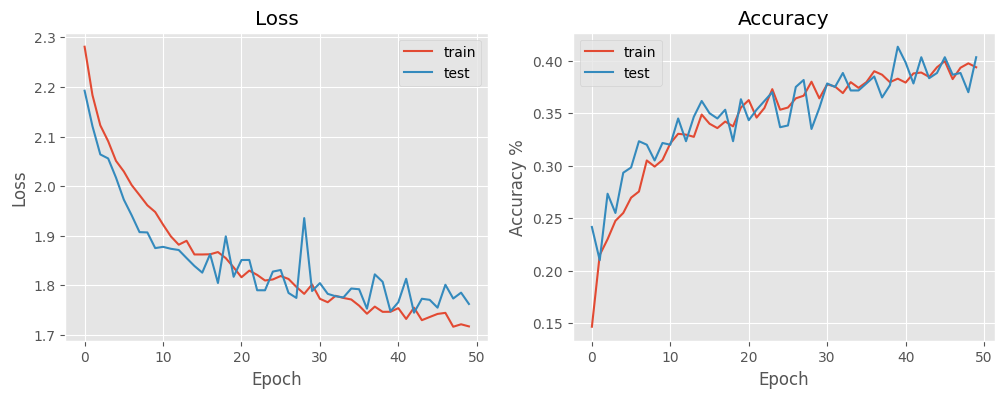

In [105]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='train')
plt.plot(cnn_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='train')
plt.plot(cnn_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()


### CNN Number 2

For our next CNN, we decided to add another cnn layer and dense layer. As well as, add dropout after the cnn layers and dense layer.

Model: "cnn2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_14 (RandomFlip  (None, 32, 32, 1)         0         
 )                                                               
                                                                 
 random_rotation_14 (Random  (None, 32, 32, 1)         0         
 Rotation)                                                       
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 16, 16, 64)        18496     
                                                              

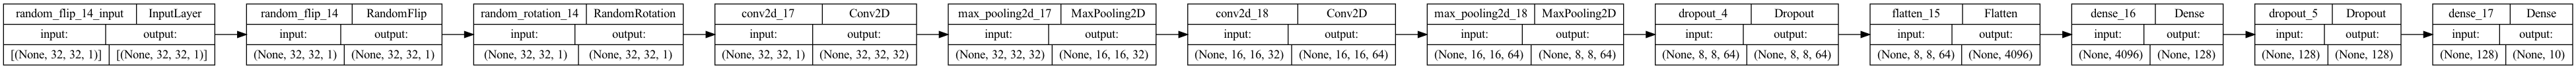

In [95]:
cnn2 = Sequential(name='cnn2')
# Add data augmentation layers
cnn2.add(RandomFlip('horizontal'))
cnn2.add(RandomRotation(0.2))

filters = [32, 64]
for filter in filters:
    cnn2.add(Conv2D(filter, (3, 3), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), activation='relu'))
    cnn2.add(MaxPooling2D(pool_size=(2, 2)))

# Add dense layers
cnn2.add(Dropout(0.25))
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.4))
cnn2.add(Dense(N_CLASSES, activation='softmax'))

cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn2.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 1))

print(cnn2.summary())

# Plot the model
plot_model(
    cnn2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [103]:
cnn2_history = cnn2.fit(X_train, y_train_ohe, epochs=50, batch_size=128, shuffle=True, validation_data=(X_test, y_test_ohe), verbose=1)

Epoch 1/50


2023-11-15 10:11:38.334140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-15 10:11:38.489488: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 3/19 [===>..........................] - ETA: 1s - loss: 2.2981 - accuracy: 0.1172

2023-11-15 10:11:41.500241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:41.579285: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:41.648151: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 2.3109 - accuracy: 0.1159

2023-11-15 10:11:41.720764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:41.792596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:41.868717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/19 [=============>................] - ETA: 0s - loss: 2.3271 - accuracy: 0.1042

2023-11-15 10:11:41.942687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.026863: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.104574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/19 [===================>..........] - ETA: 0s - loss: 2.3217 - accuracy: 0.1022

2023-11-15 10:11:42.178476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.247882: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.313337: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.377727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/19 [=========================>....] - ETA: 0s - loss: 2.3169 - accuracy: 0.1029

2023-11-15 10:11:42.447651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.510596: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.571320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:42.640667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 2.3142 - accuracy: 0.1076

2023-11-15 10:11:42.706901: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.3136 - accuracy: 0.1096

2023-11-15 10:11:44.831276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 8s 246ms/step - loss: 2.3136 - accuracy: 0.1096 - val_loss: 2.2713 - val_accuracy: 0.1483
Epoch 2/50
 2/19 [==>...........................] - ETA: 1s - loss: 2.2707 - accuracy: 0.1445

2023-11-15 10:11:45.927226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.001558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.070450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 2.2795 - accuracy: 0.1315

2023-11-15 10:11:46.136104: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.201921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.266500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.332241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 2.2755 - accuracy: 0.1406

2023-11-15 10:11:46.398687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.461039: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.525312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.591333: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 2.2668 - accuracy: 0.1401

2023-11-15 10:11:46.653865: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.717362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.779873: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.842843: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 2.2645 - accuracy: 0.1393

2023-11-15 10:11:46.909894: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:46.973106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.034386: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.098584: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 2.2629 - accuracy: 0.1437 - val_loss: 2.1907 - val_accuracy: 0.2267
Epoch 3/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.2299 - accuracy: 0.1953

2023-11-15 10:11:47.424859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.491771: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.553075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.614959: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.2139 - accuracy: 0.1908

2023-11-15 10:11:47.679632: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.746785: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.808811: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.870728: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.2073 - accuracy: 0.1974

2023-11-15 10:11:47.933649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:47.999379: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.060961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.125003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.2001 - accuracy: 0.2062

2023-11-15 10:11:48.190678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.257393: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.321665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.383194: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.2034 - accuracy: 0.1975

2023-11-15 10:11:48.454128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.517582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.580119: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 2.2034 - accuracy: 0.1975 - val_loss: 2.0683 - val_accuracy: 0.2483
Epoch 4/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.1394 - accuracy: 0.2474

2023-11-15 10:11:48.895907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:48.960980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.024046: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.084096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.1098 - accuracy: 0.2422

2023-11-15 10:11:49.147200: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.209826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.273439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.337604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.1264 - accuracy: 0.2330

2023-11-15 10:11:49.403240: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.467944: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.532491: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.596655: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.1190 - accuracy: 0.2318

2023-11-15 10:11:49.668052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.738742: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.801817: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.863896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.1201 - accuracy: 0.2292

2023-11-15 10:11:49.928732: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:49.990508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.051298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 2.1201 - accuracy: 0.2292 - val_loss: 1.9668 - val_accuracy: 0.2833
Epoch 5/50
 3/19 [===>..........................] - ETA: 1s - loss: 2.1244 - accuracy: 0.2266

2023-11-15 10:11:50.363122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.429514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.494308: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.558212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0758 - accuracy: 0.2266

2023-11-15 10:11:50.621024: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.687042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.750641: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.814673: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0709 - accuracy: 0.2280

2023-11-15 10:11:50.881284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:50.943524: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.008474: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.073138: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0799 - accuracy: 0.2307

2023-11-15 10:11:51.139148: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.200971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.262324: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.327665: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0621 - accuracy: 0.2371

2023-11-15 10:11:51.391181: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.453696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.517653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 2.0621 - accuracy: 0.2371 - val_loss: 1.9110 - val_accuracy: 0.3167
Epoch 6/50
 3/19 [===>..........................] - ETA: 1s - loss: 2.1028 - accuracy: 0.2500

2023-11-15 10:11:51.825426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.889129: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:51.953459: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.017238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0653 - accuracy: 0.2567

2023-11-15 10:11:52.082330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.147701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.209334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.272543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0380 - accuracy: 0.2635

2023-11-15 10:11:52.337605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.401000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.464210: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.526419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0461 - accuracy: 0.2583

2023-11-15 10:11:52.589886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.652030: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.714066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.778144: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0383 - accuracy: 0.2575

2023-11-15 10:11:52.840117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.901543: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:52.965847: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 2.0383 - accuracy: 0.2575 - val_loss: 1.8739 - val_accuracy: 0.3167
Epoch 7/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9598 - accuracy: 0.2969

2023-11-15 10:11:53.279821: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.345127: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.410112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.473608: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 2.0084 - accuracy: 0.2612

2023-11-15 10:11:53.539986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.606472: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.670137: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.732318: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 2.0044 - accuracy: 0.2670

2023-11-15 10:11:53.796819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.862500: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.923396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:53.986503: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 2.0006 - accuracy: 0.2693

2023-11-15 10:11:54.052092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.115738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.180388: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.245891: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 2.0001 - accuracy: 0.2667

2023-11-15 10:11:54.312293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.377871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.439452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 2.0001 - accuracy: 0.2667 - val_loss: 1.8593 - val_accuracy: 0.3283
Epoch 8/50
 3/19 [===>..........................] - ETA: 1s - loss: 2.0292 - accuracy: 0.2760

2023-11-15 10:11:54.743433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.806750: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.872196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:54.935279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 1.9833 - accuracy: 0.2956

2023-11-15 10:11:55.000135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.072853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.145829: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.9996 - accuracy: 0.2727

2023-11-15 10:11:55.207350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.272715: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.336895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.398967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.9998 - accuracy: 0.2790

2023-11-15 10:11:55.465275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.530650: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.592086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.656929: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.9909 - accuracy: 0.2804

2023-11-15 10:11:55.722791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.785348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.849319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:55.915063: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9965 - accuracy: 0.2792 - val_loss: 1.8860 - val_accuracy: 0.3267
Epoch 9/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9569 - accuracy: 0.2786

2023-11-15 10:11:56.224753: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.287191: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.350201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.415798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9400 - accuracy: 0.3158

2023-11-15 10:11:56.479047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.541794: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.606552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.667349: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9676 - accuracy: 0.3089

2023-11-15 10:11:56.733774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.797431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.858454: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:56.920530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9593 - accuracy: 0.3026

2023-11-15 10:11:56.986971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.049371: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.114440: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.174556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9577 - accuracy: 0.3021

2023-11-15 10:11:57.237501: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.300874: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.364815: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.9577 - accuracy: 0.3021 - val_loss: 1.8610 - val_accuracy: 0.3283
Epoch 10/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9284 - accuracy: 0.2786

2023-11-15 10:11:57.674842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.737330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.803167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.866709: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8919 - accuracy: 0.2946

2023-11-15 10:11:57.929935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:57.994040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.056473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.120589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9149 - accuracy: 0.3004

2023-11-15 10:11:58.187252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.249881: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.314635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.375822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9352 - accuracy: 0.2958

2023-11-15 10:11:58.438152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.500198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.561054: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.625134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9326 - accuracy: 0.3004

2023-11-15 10:11:58.691047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.754435: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:58.815758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.9326 - accuracy: 0.3004 - val_loss: 1.8323 - val_accuracy: 0.3333
Epoch 11/50
 3/19 [===>..........................] - ETA: 0s - loss: 2.0206 - accuracy: 0.3359

2023-11-15 10:11:59.128498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.194268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.255368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.315866: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9443 - accuracy: 0.3304

2023-11-15 10:11:59.382220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.444228: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.506724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.571253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9350 - accuracy: 0.3381

2023-11-15 10:11:59.639917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.706306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.766956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.830383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.9293 - accuracy: 0.3292

2023-11-15 10:11:59.896081: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:11:59.961364: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.032243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.9222 - accuracy: 0.3242

2023-11-15 10:12:00.107689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.174805: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.236378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.301000: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9218 - accuracy: 0.3267 - val_loss: 1.9397 - val_accuracy: 0.3150
Epoch 12/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9769 - accuracy: 0.2865

2023-11-15 10:12:00.609840: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.675017: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.740358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.803945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9416 - accuracy: 0.3103

2023-11-15 10:12:00.866220: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.929799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:00.993654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.058092: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9456 - accuracy: 0.3089

2023-11-15 10:12:01.135687: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.200329: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.264283: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.326387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9347 - accuracy: 0.3109

2023-11-15 10:12:01.394509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.463490: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.526414: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.591522: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9225 - accuracy: 0.3129

2023-11-15 10:12:01.656837: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.723312: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:01.787921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9225 - accuracy: 0.3129 - val_loss: 1.9058 - val_accuracy: 0.3317
Epoch 13/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8917 - accuracy: 0.3307

2023-11-15 10:12:02.101651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.165130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.230356: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.293727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8957 - accuracy: 0.3225

2023-11-15 10:12:02.360130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.423339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.487617: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.550879: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9111 - accuracy: 0.3125

2023-11-15 10:12:02.617045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.682740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.746773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.810091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9204 - accuracy: 0.3078

2023-11-15 10:12:02.873406: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:02.938648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.000099: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.060159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9187 - accuracy: 0.3100

2023-11-15 10:12:03.126609: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.191565: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.255615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.9187 - accuracy: 0.3100 - val_loss: 1.8023 - val_accuracy: 0.3533
Epoch 14/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8892 - accuracy: 0.3255

2023-11-15 10:12:03.558540: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.620691: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.684350: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.749198: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8813 - accuracy: 0.3170

2023-11-15 10:12:03.811964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.873979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.935975: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:03.999165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9061 - accuracy: 0.3139

2023-11-15 10:12:04.065035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.127688: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.189372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.252380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9135 - accuracy: 0.3094

2023-11-15 10:12:04.318121: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.385643: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.450215: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.514103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8998 - accuracy: 0.3133

2023-11-15 10:12:04.579618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.642117: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:04.703941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.8998 - accuracy: 0.3133 - val_loss: 1.8344 - val_accuracy: 0.3450
Epoch 15/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8692 - accuracy: 0.3646

2023-11-15 10:12:05.003022: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.069781: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.135298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.200690: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 1.9067 - accuracy: 0.3346

2023-11-15 10:12:05.279950: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.357971: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.425208: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.8925 - accuracy: 0.3273

2023-11-15 10:12:05.490001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.557464: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.618618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.683193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8996 - accuracy: 0.3225

2023-11-15 10:12:05.746965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.808867: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.868871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:05.932555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.9094 - accuracy: 0.3225

2023-11-15 10:12:05.998765: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.060711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.122252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.186140: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9046 - accuracy: 0.3229 - val_loss: 1.7879 - val_accuracy: 0.3667
Epoch 16/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9840 - accuracy: 0.2891

2023-11-15 10:12:06.491583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.557184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.621631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.684700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9062 - accuracy: 0.3326

2023-11-15 10:12:06.748162: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.814314: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.875412: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:06.939597: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9284 - accuracy: 0.3175

2023-11-15 10:12:07.001740: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.064859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.129934: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.192271: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9142 - accuracy: 0.3109

2023-11-15 10:12:07.256955: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.322266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.387178: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.450606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9139 - accuracy: 0.3113

2023-11-15 10:12:07.517516: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.583183: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:07.644611: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.9139 - accuracy: 0.3113 - val_loss: 1.8639 - val_accuracy: 0.3567
Epoch 17/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9640 - accuracy: 0.3177

2023-11-15 10:12:07.946020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.010799: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.073334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.138537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9222 - accuracy: 0.3203

2023-11-15 10:12:08.205284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.271640: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.335402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.398637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9183 - accuracy: 0.3189

2023-11-15 10:12:08.462361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.524877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.588646: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.653582: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9287 - accuracy: 0.3125

2023-11-15 10:12:08.719091: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.785019: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.849803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:08.915281: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.9202 - accuracy: 0.3104

2023-11-15 10:12:08.982172: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.049295: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.112907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.9202 - accuracy: 0.3104 - val_loss: 1.7524 - val_accuracy: 0.3800
Epoch 18/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9497 - accuracy: 0.3177

2023-11-15 10:12:09.424844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.488135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.553392: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.616871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9509 - accuracy: 0.3214

2023-11-15 10:12:09.681860: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.748100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.813257: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:09.876997: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9077 - accuracy: 0.3288

2023-11-15 10:12:09.940680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.006096: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.070743: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.134526: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8893 - accuracy: 0.3307

2023-11-15 10:12:10.200890: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.267744: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.338631: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.9018 - accuracy: 0.3238

2023-11-15 10:12:10.402279: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.467956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.533678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.598602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9024 - accuracy: 0.3237 - val_loss: 1.9009 - val_accuracy: 0.3650
Epoch 19/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.7702 - accuracy: 0.3776

2023-11-15 10:12:10.907992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:10.973569: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.038822: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.106602: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8420 - accuracy: 0.3516

2023-11-15 10:12:11.174113: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.239994: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.301088: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.365009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8722 - accuracy: 0.3409

2023-11-15 10:12:11.427727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.492268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.556629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.619689: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8829 - accuracy: 0.3396

2023-11-15 10:12:11.685476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.748192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.812339: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:11.876999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8969 - accuracy: 0.3358

2023-11-15 10:12:11.942693: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.006246: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.070041: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8969 - accuracy: 0.3358 - val_loss: 1.7861 - val_accuracy: 0.3783
Epoch 20/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9011 - accuracy: 0.3542

2023-11-15 10:12:12.377767: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.446247: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.513495: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.577253: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9034 - accuracy: 0.3415

2023-11-15 10:12:12.643301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.706193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.767427: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.833884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8980 - accuracy: 0.3388

2023-11-15 10:12:12.898431: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:12.965300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.029284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.095616: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8968 - accuracy: 0.3391

2023-11-15 10:12:13.160635: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.223547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.288100: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.351760: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8915 - accuracy: 0.3329

2023-11-15 10:12:13.418588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.483684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.548884: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8915 - accuracy: 0.3329 - val_loss: 1.7686 - val_accuracy: 0.3967
Epoch 21/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8461 - accuracy: 0.3281

2023-11-15 10:12:13.853058: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.915418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:13.981011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.045826: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8634 - accuracy: 0.3259

2023-11-15 10:12:14.109511: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.174983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.240021: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.304187: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8800 - accuracy: 0.3153

2023-11-15 10:12:14.369423: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.433108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.494001: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.556051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8732 - accuracy: 0.3255

2023-11-15 10:12:14.618980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.685514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.746853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.807163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8841 - accuracy: 0.3254

2023-11-15 10:12:14.871195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:14.936480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.000877: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.8841 - accuracy: 0.3254 - val_loss: 1.7395 - val_accuracy: 0.3950
Epoch 22/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9181 - accuracy: 0.2995

2023-11-15 10:12:15.308507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.374131: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.441452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 1.9053 - accuracy: 0.3060

2023-11-15 10:12:15.510680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.577377: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.640704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.705176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.8531 - accuracy: 0.3305

2023-11-15 10:12:15.776783: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.840512: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.900562: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:15.965188: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8433 - accuracy: 0.3270

2023-11-15 10:12:16.031957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.095056: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.158695: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.220658: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8543 - accuracy: 0.3273

2023-11-15 10:12:16.284044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.349776: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.414248: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.479298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8626 - accuracy: 0.3246 - val_loss: 1.8271 - val_accuracy: 0.3650
Epoch 23/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8665 - accuracy: 0.3646

2023-11-15 10:12:16.780766: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.846656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.912481: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:16.976176: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8418 - accuracy: 0.3493

2023-11-15 10:12:17.042182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.106922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.167958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.232141: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8437 - accuracy: 0.3501

2023-11-15 10:12:17.298727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.364978: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.426795: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.491171: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8820 - accuracy: 0.3464

2023-11-15 10:12:17.558087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.623674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.693924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.757831: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8798 - accuracy: 0.3446

2023-11-15 10:12:17.822964: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.884745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:17.946016: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8798 - accuracy: 0.3446 - val_loss: 1.7438 - val_accuracy: 0.3967
Epoch 24/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9563 - accuracy: 0.3177

2023-11-15 10:12:18.255419: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.318192: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.383839: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.448627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8568 - accuracy: 0.3348

2023-11-15 10:12:18.515250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.582034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.648389: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.712372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8673 - accuracy: 0.3494

2023-11-15 10:12:18.780360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.846965: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.911921: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:18.975842: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8434 - accuracy: 0.3542

2023-11-15 10:12:19.040020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.104238: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.168576: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.232366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8527 - accuracy: 0.3483

2023-11-15 10:12:19.295548: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.360071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.421731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8527 - accuracy: 0.3483 - val_loss: 1.7817 - val_accuracy: 0.3833
Epoch 25/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8127 - accuracy: 0.3438

2023-11-15 10:12:19.724439: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.790898: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.855916: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:19.919445: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8474 - accuracy: 0.3538

2023-11-15 10:12:19.985374: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.051538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.115696: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.179182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8480 - accuracy: 0.3487

2023-11-15 10:12:20.245493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.318551: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.382268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8575 - accuracy: 0.3471

2023-11-15 10:12:20.447418: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.514179: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.582446: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/19 [=========================>....] - ETA: 0s - loss: 1.8610 - accuracy: 0.3456

2023-11-15 10:12:20.650135: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.716484: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.777654: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:20.840370: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8666 - accuracy: 0.3417

2023-11-15 10:12:20.907448: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8666 - accuracy: 0.3417 - val_loss: 1.8132 - val_accuracy: 0.3850
Epoch 26/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8036 - accuracy: 0.3438

2023-11-15 10:12:21.217052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.282962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.344731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.409156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8362 - accuracy: 0.3359

2023-11-15 10:12:21.475290: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.542174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.609539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.673534: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8451 - accuracy: 0.3409

2023-11-15 10:12:21.739917: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.806152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.870900: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:21.935369: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8728 - accuracy: 0.3417

2023-11-15 10:12:22.000601: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.063887: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.131159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.192981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8706 - accuracy: 0.3388

2023-11-15 10:12:22.259243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.325284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.389967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8706 - accuracy: 0.3388 - val_loss: 1.8069 - val_accuracy: 0.3633
Epoch 27/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8941 - accuracy: 0.3307

2023-11-15 10:12:22.691791: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.757741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.823810: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:22.886087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8778 - accuracy: 0.3382

2023-11-15 10:12:22.950902: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.016671: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.081618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.147066: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8363 - accuracy: 0.3551

2023-11-15 10:12:23.215221: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.282160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.346380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.407828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8595 - accuracy: 0.3443

2023-11-15 10:12:23.472812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.538774: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.602824: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.667457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8671 - accuracy: 0.3396

2023-11-15 10:12:23.733585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.798773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:23.862527: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8671 - accuracy: 0.3396 - val_loss: 1.7115 - val_accuracy: 0.3983
Epoch 28/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9160 - accuracy: 0.3490

2023-11-15 10:12:24.164980: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.231557: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.297103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.360550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8566 - accuracy: 0.3482

2023-11-15 10:12:24.422330: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.488201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.551686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.615510: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8311 - accuracy: 0.3601

2023-11-15 10:12:24.678232: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.740555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.801082: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:24.865193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8376 - accuracy: 0.3538

2023-11-15 10:12:24.935319: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.008895: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.082614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8451 - accuracy: 0.3451

2023-11-15 10:12:25.147033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.213629: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.277827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.340167: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8562 - accuracy: 0.3400 - val_loss: 1.8674 - val_accuracy: 0.3567
Epoch 29/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9545 - accuracy: 0.2865

2023-11-15 10:12:25.651763: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.717542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.783532: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.848539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8718 - accuracy: 0.3170

2023-11-15 10:12:25.914116: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:25.981378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.046910: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.110433: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8717 - accuracy: 0.3182

2023-11-15 10:12:26.175725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.241986: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.306436: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.367413: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8684 - accuracy: 0.3281

2023-11-15 10:12:26.433588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.499812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.564291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.625165: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8670 - accuracy: 0.3288

2023-11-15 10:12:26.691492: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.758193: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:26.817919: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8670 - accuracy: 0.3288 - val_loss: 1.8865 - val_accuracy: 0.3517
Epoch 30/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8108 - accuracy: 0.3464

2023-11-15 10:12:27.131185: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.194558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.265981: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 1.8407 - accuracy: 0.3281

2023-11-15 10:12:27.331461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.394725: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.456859: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.517990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.9004 - accuracy: 0.3078

2023-11-15 10:12:27.584381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.650130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.714649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.778062: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8606 - accuracy: 0.3287

2023-11-15 10:12:27.842644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.907886: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:27.969201: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.032644: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8545 - accuracy: 0.3342

2023-11-15 10:12:28.098398: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.161244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.225109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.287701: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8544 - accuracy: 0.3363 - val_loss: 1.7730 - val_accuracy: 0.3450
Epoch 31/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8041 - accuracy: 0.3594

2023-11-15 10:12:28.595941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.660083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.724804: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.785869: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8910 - accuracy: 0.3248

2023-11-15 10:12:28.851417: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.916606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:28.981758: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.041706: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9040 - accuracy: 0.3210

2023-11-15 10:12:29.108205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.173777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.238196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.302071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.9267 - accuracy: 0.3172

2023-11-15 10:12:29.367383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.432537: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.496366: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.559666: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.9068 - accuracy: 0.3260

2023-11-15 10:12:29.629212: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.701502: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:29.772660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.9021 - accuracy: 0.3292 - val_loss: 1.7155 - val_accuracy: 0.4133
Epoch 32/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9432 - accuracy: 0.3099

2023-11-15 10:12:30.077854: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.142649: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.207107: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.272227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9063 - accuracy: 0.3348

2023-11-15 10:12:30.335352: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.401128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.465284: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.529711: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8727 - accuracy: 0.3317

2023-11-15 10:12:30.592097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.658878: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.723969: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.789293: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8834 - accuracy: 0.3333

2023-11-15 10:12:30.856979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.918684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:30.983256: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.048579: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8757 - accuracy: 0.3400

2023-11-15 10:12:31.116555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.184032: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.244473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8757 - accuracy: 0.3400 - val_loss: 1.7419 - val_accuracy: 0.3617
Epoch 33/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.7488 - accuracy: 0.3880

2023-11-15 10:12:31.554738: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.622163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.684773: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.749615: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8481 - accuracy: 0.3605

2023-11-15 10:12:31.817003: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.883507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:31.945777: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.010723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8386 - accuracy: 0.3629

2023-11-15 10:12:32.074482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.141383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.206875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.271724: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8624 - accuracy: 0.3573

2023-11-15 10:12:32.336275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.401334: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.465637: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.526827: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8682 - accuracy: 0.3508

2023-11-15 10:12:32.591974: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.657835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:32.723536: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8682 - accuracy: 0.3508 - val_loss: 1.7174 - val_accuracy: 0.4183
Epoch 34/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8160 - accuracy: 0.3776

2023-11-15 10:12:33.028307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.093957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.160514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.223939: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8780 - accuracy: 0.3527

2023-11-15 10:12:33.290473: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.354416: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.418226: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.483871: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8938 - accuracy: 0.3416

2023-11-15 10:12:33.549184: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.615274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.681381: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.745051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8687 - accuracy: 0.3557

2023-11-15 10:12:33.807648: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.875114: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:33.940455: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.003764: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8567 - accuracy: 0.3542

2023-11-15 10:12:34.071517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.138035: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.201497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 80ms/step - loss: 1.8567 - accuracy: 0.3542 - val_loss: 1.7737 - val_accuracy: 0.3733
Epoch 35/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8313 - accuracy: 0.3125

2023-11-15 10:12:34.526525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.590553: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.655539: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.716945: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9083 - accuracy: 0.3281

2023-11-15 10:12:34.782968: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.849990: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.911269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:34.973358: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9053 - accuracy: 0.3239

2023-11-15 10:12:35.040360: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.103568: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.168020: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.231618: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8981 - accuracy: 0.3286

2023-11-15 10:12:35.298779: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.365222: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.426434: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.490876: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8931 - accuracy: 0.3288

2023-11-15 10:12:35.558266: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.625426: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:35.687958: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8931 - accuracy: 0.3288 - val_loss: 1.6794 - val_accuracy: 0.4233
Epoch 36/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9564 - accuracy: 0.2917

2023-11-15 10:12:35.993059: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.057373: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.120159: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.183538: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8567 - accuracy: 0.3348

2023-11-15 10:12:36.250908: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.313812: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.375972: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.440365: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8652 - accuracy: 0.3430

2023-11-15 10:12:36.507126: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.573163: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.638160: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.702275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8548 - accuracy: 0.3443

2023-11-15 10:12:36.765832: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.833239: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.898515: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:36.962598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8724 - accuracy: 0.3392

2023-11-15 10:12:37.026493: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.088581: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.150712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8724 - accuracy: 0.3392 - val_loss: 1.7579 - val_accuracy: 0.4050
Epoch 37/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.8732 - accuracy: 0.3281

2023-11-15 10:12:37.454723: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.520734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.584189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.645819: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8527 - accuracy: 0.3449

2023-11-15 10:12:37.712252: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.778409: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.840368: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:37.902624: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8390 - accuracy: 0.3480

2023-11-15 10:12:37.968387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.037195: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.103268: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.167498: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8376 - accuracy: 0.3536

2023-11-15 10:12:38.234042: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.297152: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.361547: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.424684: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8465 - accuracy: 0.3500

2023-11-15 10:12:38.491011: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.556402: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.620106: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8465 - accuracy: 0.3500 - val_loss: 1.6607 - val_accuracy: 0.4150
Epoch 38/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8715 - accuracy: 0.3411

2023-11-15 10:12:38.924105: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:38.990558: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.057071: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.121741: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 6/19 [========>.....................] - ETA: 0s - loss: 1.8358 - accuracy: 0.3516

2023-11-15 10:12:39.193803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.265507: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.336034: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.8367 - accuracy: 0.3445

2023-11-15 10:12:39.399156: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.465269: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.530946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.593848: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8509 - accuracy: 0.3482

2023-11-15 10:12:39.657150: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.723803: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.785896: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.850844: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8393 - accuracy: 0.3533

2023-11-15 10:12:39.914961: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:39.982204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.049438: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.114828: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8456 - accuracy: 0.3504 - val_loss: 1.7019 - val_accuracy: 0.4050
Epoch 39/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8474 - accuracy: 0.3672

2023-11-15 10:12:40.421299: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.485300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.550476: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.613267: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8657 - accuracy: 0.3627

2023-11-15 10:12:40.677008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.743122: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.805528: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:40.868983: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8376 - accuracy: 0.3651

2023-11-15 10:12:40.935449: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.001175: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.061552: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.124984: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8462 - accuracy: 0.3583

2023-11-15 10:12:41.188051: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.250542: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.315457: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.380651: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8370 - accuracy: 0.3592

2023-11-15 10:12:41.443962: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.506700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.567008: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.8370 - accuracy: 0.3592 - val_loss: 1.6766 - val_accuracy: 0.4017
Epoch 40/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8489 - accuracy: 0.3464

2023-11-15 10:12:41.873023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:41.935517: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.000681: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.065217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.9025 - accuracy: 0.3359

2023-11-15 10:12:42.132244: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.198566: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.260702: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.325525: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8675 - accuracy: 0.3324

2023-11-15 10:12:42.391634: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.455180: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.520189: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.584593: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8397 - accuracy: 0.3417

2023-11-15 10:12:42.648383: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.714531: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.778967: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.841956: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8492 - accuracy: 0.3417

2023-11-15 10:12:42.909097: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:42.979321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.042835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8492 - accuracy: 0.3417 - val_loss: 1.7327 - val_accuracy: 0.4017
Epoch 41/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.7663 - accuracy: 0.3802

2023-11-15 10:12:43.349161: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.415450: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.481514: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.545530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8056 - accuracy: 0.3761

2023-11-15 10:12:43.610153: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.676047: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.736926: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.800341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


10/19 [==============>...............] - ETA: 0s - loss: 1.8257 - accuracy: 0.3750

2023-11-15 10:12:43.868306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:43.937991: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.015954: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8183 - accuracy: 0.3767

2023-11-15 10:12:44.084727: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.152112: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.217461: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.282992: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8195 - accuracy: 0.3737

2023-11-15 10:12:44.347614: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.415361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.479932: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.542341: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8188 - accuracy: 0.3738 - val_loss: 1.7042 - val_accuracy: 0.4233
Epoch 42/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8284 - accuracy: 0.3620

2023-11-15 10:12:44.837946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.902752: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:44.968966: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.032462: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8108 - accuracy: 0.3661

2023-11-15 10:12:45.095272: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.161674: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.226217: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.287255: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8197 - accuracy: 0.3658

2023-11-15 10:12:45.354227: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.420287: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.482361: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.546798: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8212 - accuracy: 0.3526

2023-11-15 10:12:45.615033: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.682045: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.745835: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.810103: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8126 - accuracy: 0.3546

2023-11-15 10:12:45.873957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:45.940998: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.001348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8126 - accuracy: 0.3546 - val_loss: 1.7362 - val_accuracy: 0.4017
Epoch 43/50
 3/19 [===>..........................] - ETA: 0s - loss: 1.7185 - accuracy: 0.3958

2023-11-15 10:12:46.310075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.376143: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.438265: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.500236: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.7899 - accuracy: 0.3717

2023-11-15 10:12:46.565782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.629301: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.693745: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.758206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8067 - accuracy: 0.3601

2023-11-15 10:12:46.823345: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.889508: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:46.953038: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.016166: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8207 - accuracy: 0.3568

2023-11-15 10:12:47.082197: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.147851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.210037: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.274606: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8233 - accuracy: 0.3554

2023-11-15 10:12:47.339250: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.408989: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.474808: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8233 - accuracy: 0.3554 - val_loss: 1.8267 - val_accuracy: 0.3617
Epoch 44/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.9222 - accuracy: 0.3516

2023-11-15 10:12:47.788836: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.854717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.921580: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:47.984489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8977 - accuracy: 0.3415

2023-11-15 10:12:48.046704: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.110588: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.176769: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.243807: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.9119 - accuracy: 0.3317

2023-11-15 10:12:48.307497: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.374136: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.434938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.499196: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.9061 - accuracy: 0.3337

2023-11-15 10:12:48.569298: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.639734: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.708230: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8806 - accuracy: 0.3377

2023-11-15 10:12:48.772851: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.837087: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.901274: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:48.962686: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8826 - accuracy: 0.3379 - val_loss: 1.7650 - val_accuracy: 0.3617
Epoch 45/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8340 - accuracy: 0.3698

2023-11-15 10:12:49.269336: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.332086: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.398123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.462941: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8480 - accuracy: 0.3728

2023-11-15 10:12:49.529009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.595638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.659870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.724321: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8377 - accuracy: 0.3665

2023-11-15 10:12:49.791733: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.859204: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.925036: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:49.989487: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8504 - accuracy: 0.3651

2023-11-15 10:12:50.056838: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.123555: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.188627: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.249585: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8565 - accuracy: 0.3638

2023-11-15 10:12:50.315130: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.379396: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.443598: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8565 - accuracy: 0.3638 - val_loss: 1.6613 - val_accuracy: 0.4017
Epoch 46/50
 2/19 [==>...........................] - ETA: 1s - loss: 1.7515 - accuracy: 0.3711

2023-11-15 10:12:50.748348: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.822243: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:50.889607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 5/19 [======>.......................] - ETA: 0s - loss: 1.9123 - accuracy: 0.3359

2023-11-15 10:12:50.956018: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.020935: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.094083: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 9/19 [=============>................] - ETA: 0s - loss: 1.8743 - accuracy: 0.3602

2023-11-15 10:12:51.202289: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.268663: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.334390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.395915: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


13/19 [===================>..........] - ETA: 0s - loss: 1.8846 - accuracy: 0.3480

2023-11-15 10:12:51.463134: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.528712: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.592660: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.655792: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


17/19 [=========================>....] - ETA: 0s - loss: 1.8829 - accuracy: 0.3447

2023-11-15 10:12:51.723327: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.789027: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.854055: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:51.918656: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8878 - accuracy: 0.3446

2023-11-15 10:12:51.984814: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 2s 82ms/step - loss: 1.8878 - accuracy: 0.3446 - val_loss: 1.7375 - val_accuracy: 0.3933
Epoch 47/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8647 - accuracy: 0.3672

2023-11-15 10:12:52.292519: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.360263: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.426499: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.490530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8860 - accuracy: 0.3471

2023-11-15 10:12:52.555782: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.617700: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.681680: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.742556: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8796 - accuracy: 0.3402

2023-11-15 10:12:52.808372: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.874214: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.935307: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:52.996875: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


14/19 [=====================>........] - ETA: 0s - loss: 1.8829 - accuracy: 0.3398

2023-11-15 10:12:53.061489: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.132586: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.205447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


18/19 [===========================>..] - ETA: 0s - loss: 1.8815 - accuracy: 0.3472

2023-11-15 10:12:53.272937: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.338340: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.405563: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.468275: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 79ms/step - loss: 1.8839 - accuracy: 0.3483 - val_loss: 1.6571 - val_accuracy: 0.4383
Epoch 48/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8061 - accuracy: 0.3464

2023-11-15 10:12:53.774717: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.837205: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.898574: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:53.963922: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8240 - accuracy: 0.3549

2023-11-15 10:12:54.031378: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.100052: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.163550: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.229638: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8259 - accuracy: 0.3608

2023-11-15 10:12:54.295149: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.361504: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.426044: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.489605: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8195 - accuracy: 0.3656

2023-11-15 10:12:54.552561: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.618009: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.681040: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.745300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8275 - accuracy: 0.3646

2023-11-15 10:12:54.807924: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.870322: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:54.931387: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8275 - accuracy: 0.3646 - val_loss: 1.7042 - val_accuracy: 0.4250
Epoch 49/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.8964 - accuracy: 0.3255

2023-11-15 10:12:55.236292: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.302855: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.369591: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.431291: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8738 - accuracy: 0.3315

2023-11-15 10:12:55.497466: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.564108: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.628182: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.692938: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8341 - accuracy: 0.3374

2023-11-15 10:12:55.756530: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.822604: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.886241: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:55.951452: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8220 - accuracy: 0.3526

2023-11-15 10:12:56.021303: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.084607: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.146589: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.208731: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8263 - accuracy: 0.3537

2023-11-15 10:12:56.274853: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.341075: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.405320: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 78ms/step - loss: 1.8263 - accuracy: 0.3537 - val_loss: 1.7449 - val_accuracy: 0.3933
Epoch 50/50
 3/19 [===>..........................] - ETA: 1s - loss: 1.7965 - accuracy: 0.3490

2023-11-15 10:12:56.707123: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.771979: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.836390: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:56.898999: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


 7/19 [==========>...................] - ETA: 0s - loss: 1.8043 - accuracy: 0.3549

2023-11-15 10:12:56.963109: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.028509: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.092482: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.156703: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


11/19 [================>.............] - ETA: 0s - loss: 1.8232 - accuracy: 0.3580

2023-11-15 10:12:57.219128: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.282447: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.346870: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.411216: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


15/19 [======================>.......] - ETA: 0s - loss: 1.8684 - accuracy: 0.3448

2023-11-15 10:12:57.477206: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.540480: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.601957: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.665380: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - ETA: 0s - loss: 1.8606 - accuracy: 0.3425

2023-11-15 10:12:57.730667: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.794946: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-15 10:12:57.859110: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.


19/19 [==============================] - 1s 77ms/step - loss: 1.8606 - accuracy: 0.3425 - val_loss: 1.7190 - val_accuracy: 0.4150


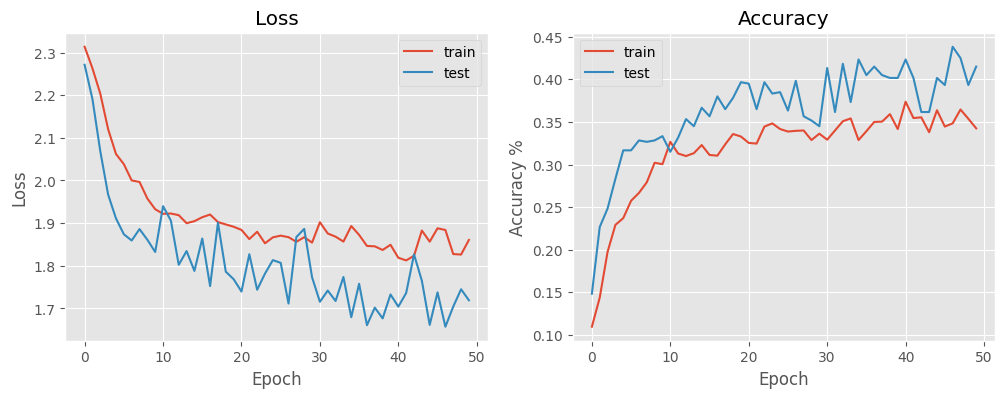

In [104]:
# Plot the loss and accuracy curves for training and validation

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn2_history.history['loss'], label='train')
plt.plot(cnn2_history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn2_history.history['accuracy'], label='train')
plt.plot(cnn2_history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy %')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.legend()

plt.show()

In [101]:
# Plot confusion matrix for cnn
from sklearn import metrics as mt
import seaborn as sns
def confusion_matrix_compare(model, model2, X_test, y_test, labels='auto'):
    plt.figure(figsize=(15, 5))
    if model is not None:
        yhat = np.argmax(model.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 1)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model.name}: {acc:.3f}')
    
    if model2 is not None:
        yhat = np.argmax(model2.predict(X_test), axis=1)
        acc = mt.accuracy_score(y_test, yhat)
        plt.subplot(1, 2, 2)
        cm = mt.confusion_matrix(y_test, yhat)
        cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
        plt.title(f'{model2.name}: {acc:.3f}')

 1/19 [>.............................] - ETA: 3s

2023-11-15 10:16:03.983701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 0s 4ms/step


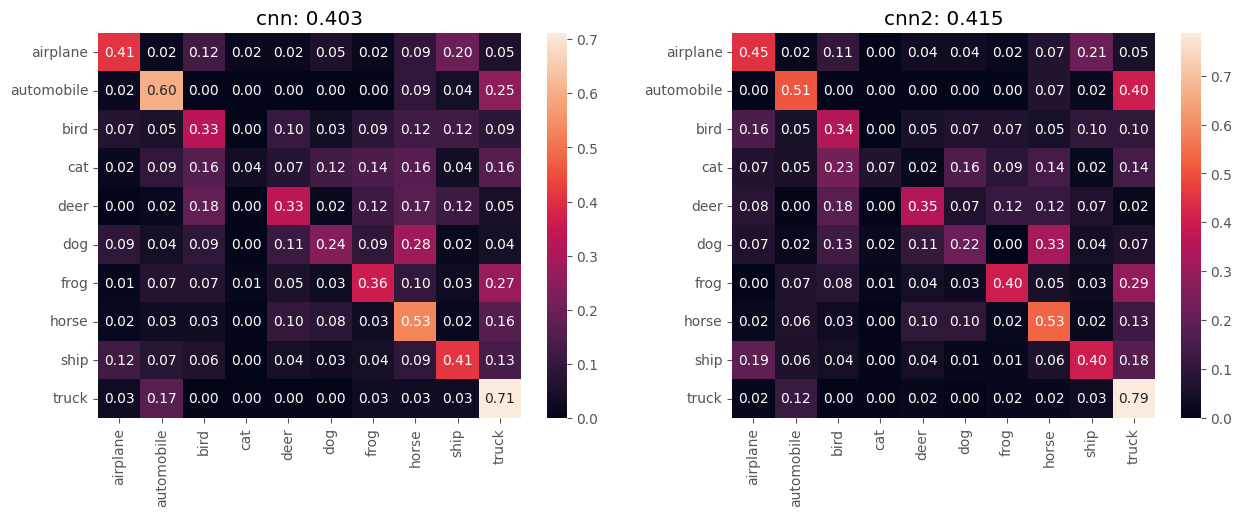

In [106]:
confusion_matrix_compare(cnn, cnn2, X_test, y_test, labels=labels)